<a href="https://colab.research.google.com/github/thetinybug/Django-Project/blob/master/BlackBox_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Một số biến toàn cục**

In [0]:
# Dataset Path
DatasetPath = "/content/drive/My Drive/Study/KLTN/Dataset/NSL-KDD-TM/"

# train_dataset_path = DatasetPath + "Attack-type Labels/SEPARATED/" + "BlackboxTrain.csv"
train_dataset_path = DatasetPath + "Attack-type Labels/PREPROCESSED/" + "KDDTrain+_label_normalized_all.csv"
test_dataset_path = DatasetPath + "Attack-type Labels/PREPROCESSED/" + "KDDTest+_label_normalized_all.csv"

# Save Model Path
SavedModelPath = "/content/drive/My Drive/Study/KLTN/Saved Model/IDSModel/Separated Dataset/"

#**1. Chuẩn bị**

##1.1 Import thư viện

###1.1.1. Cài đặt các thư viện cần thiết

In [35]:
!pip3 install numpy adabound torc sklearn matplotlib pandas

###1.1.2. Import thư viện

In [0]:
import pandas as pd
import numpy as np
import adabound
import torch as th
from torch.autograd import Variable as V
from torch import nn,optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

# Define HCM Timezone
time_zone = pytz.timezone('Asia/Ho_Chi_Minh')

##1.2 Định nghĩa hàm tạo Batch

In [0]:
# Hàm tạo Batch
def create_batch1(x,y,batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    y = y[a]

    batch_x = [x[batch_size * i : (i+1)*batch_size,:].tolist() for i in range(len(x)//batch_size)]
    batch_y = [y[batch_size * i : (i+1)*batch_size].tolist() for i in range(len(x)//batch_size)]
    return batch_x, batch_y

##1.3 Chuẩn bị dataset

In [38]:
#Prepare Dataset

# Load Dataset
train = pd.read_csv(train_dataset_path)
test = pd.read_csv(test_dataset_path)

# Convert class to Binary
train["class"] = train["class"].map(lambda x : 0 if x == "normal" else 1)
test["class"] = test["class"].map(lambda x : 0 if x == "normal" else 1)

trainx, trainy = np.array(train[train.columns[train.columns != "class"]]), np.array(train["class"])
testx, testy= np.array(test[test.columns[test.columns != "class"]]),np.array(test["class"])


# batch_size, epoch
batch_size = 1024
max_epoch = 50

# Amount of dataset
n_Train = len(trainx)
n_Test = len(testx)

print("Amout of Train Set:", n_Train)
print("Amout of Test Set:", n_Test)

Amout of Train Set: 125973
Amout of Test Set: 22544


In [39]:
print(trainx.shape)

(125973, 41)


# **2. Định nghĩa Model**

##2.1. Tạo Model

In [0]:
# Create BlackBoxIDS Model
class Blackbox_IDS(nn.Module):
    def __init__(self,input_dim, output_dim):
        super().__init__()
        self.layer = nn.Sequential(
            #nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, input_dim*2),
            nn.Dropout(0.6),   
            #nn.ELU(),
            nn.LeakyReLU(True),
           # nn.BatchNorm1d(input_dim*2),
            nn.Linear(input_dim *2, input_dim *2),
            nn.Dropout(0.5),       
           # nn.ELU(),
#            nn.ReLU(True),
            nn.LeakyReLU(True),   
          # nn.BatchNorm1d(input_dim*2),
            nn.Linear(input_dim *2, input_dim//2),
            nn.Dropout(0.5),       
#            nn.ReLU(True),
        #  nn.ELU(),
            nn.LeakyReLU(True),
           #nn.BatchNorm1d(input_dim//2),
            nn.Linear(input_dim//2,input_dim//2),
            nn.Dropout(0.4),       
        #    nn.ELU(),
#            nn.ReLU(True),
            nn.LeakyReLU(True),
            
             nn.Linear(input_dim//2,output_dim),
        )
        #nn.init.kaiming_normal_(self.layer.weight)
        self.output = nn.Sigmoid()
        #self.output = nn.Softmax()
    def forward(self,x):
        x = self.layer(x)
        return x

# Instantiate Model Class
input_dim = trainx.shape[1]     #Number of dimension from dataset
output_dim = 2                  # Label: Anomaly (1), Normaly (0)

# create BlackBoxIDS model
ids_model = Blackbox_IDS(input_dim,output_dim)

# Cross Entropy Loss  
loss_f = nn.CrossEntropyLoss()

# Adam Optimizer 
learning_rate = 0.001
opt = optim.Adam(ids_model.parameters(),lr=learning_rate)

##2.2. Hàm Train, Test

In [0]:
# Train Func
def train(x,y):
    ids_model.train()
    batch_x, batch_y = create_batch1(x,y,batch_size)
    run_loss = 0
    for x,y in zip(batch_x,batch_y):

        ids_model.zero_grad()
        x = V(th.Tensor(x),requires_grad = True)
        y = V(th.LongTensor(y))
        out = ids_model(x)
        loss = loss_f(out,y)

        run_loss += loss.item()
        loss.backward()
        opt.step()
    return run_loss/n_Train

# Test Func
def test(x,y):
    ids_model.eval()
    batch_x, batch_y = create_batch1(x,y,batch_size)
    run_loss = 0
    correct = 0
    
    with th.no_grad():
        for x,y in zip(batch_x,batch_y):
            x = th.Tensor(x)
            y = th.LongTensor(y)
            out = ids_model(x)
            # Calc Loss
            loss = loss_f(out,y)
            run_loss += loss.item()
    return run_loss/n_Test

# **3. Run Model**

IDS start training
----------------------------------------------------------------------------------------------------
Epoch 		Train Loss 			Test Loss
1 :		0.00024866689993932747 		0.0008450238955536999
2 :		0.00015183104174190846 		0.0008648025219621516
3 :		0.00014461035248127446 		0.0008738567593928513
4 :		0.0001403645883261503 		0.0009633294069403194
5 :		0.00013801173894148898 		0.0009648527730602674
6 :		0.00013614573138160242 		0.000987240834448505
7 :		0.00013496633474905905 		0.0010079044539341273
8 :		0.00013420834266645367 		0.000964255938722869
9 :		0.0001336590660846402 		0.0009797005005302455
10 :		0.00013325840478904 		0.0010318662297057293
11 :		0.0001330682381720358 		0.0009877350051788847
12 :		0.00013163568036497365 		0.0010440804598346681
13 :		0.00013217032642975362 		0.0010698567718965438
14 :		0.00013239377476715887 		0.0010060294880944842
15 :		0.0001322052646627515 		0.0009743448576874729
16 :		0.00013137392682980648 		0.001008261632335533
17 :		0.00013110793

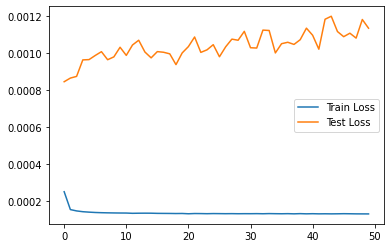

In [42]:
train_losses, test_losses = [],[]

# Run Model 
print("IDS start training")
print("-"*100)
print("Epoch \t\tTrain Loss \t\t\tTest Loss")
for epoch in range(max_epoch):
    train_loss = train(trainx,trainy)
    test_loss = test(testx,testy)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"{epoch+1} :\t\t{train_loss} \t\t{test_loss}")    
print("IDS finished training")

# Save Model & Show Loss Graph
TodayStr = datetime.now(time_zone).strftime("%Y.%m.%d-%H.%M")
th.save(ids_model.state_dict(), (SavedModelPath + "IDS_" + TodayStr + ".pth"))
plt.plot(train_losses,label = "Train Loss")
plt.plot(test_losses, label = "Test Loss")
plt.legend()
plt.show()

The Saved Model stored in [Google Drive - BlackBox IDS Model](https://drive.google.com/drive/u/1/folders/1M-xotvruMlkFNaQWPf9bpBpzgPhPLpiH)  
The Result of Code stored in [Github - Thesis](https://github.com/thetinybug/thesis-IDSGAN)